In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
plt.style.use('fivethirtyeight')

In [23]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)




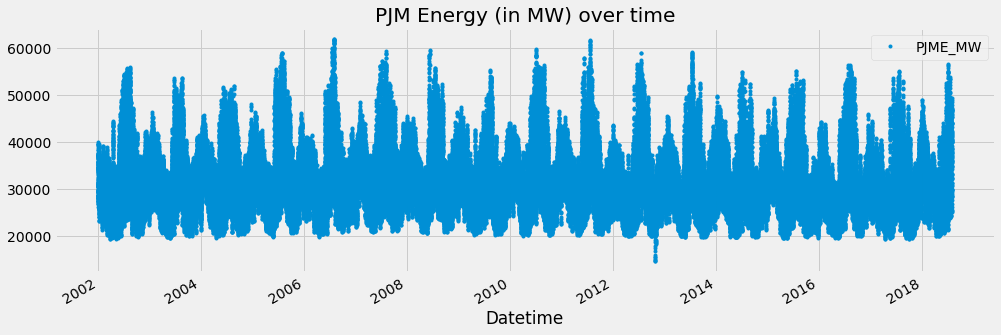

In [24]:
df.plot(style='.',
        figsize=(15, 5),
        title='PJM Energy (in MW) over time')
plt.show()

In [25]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

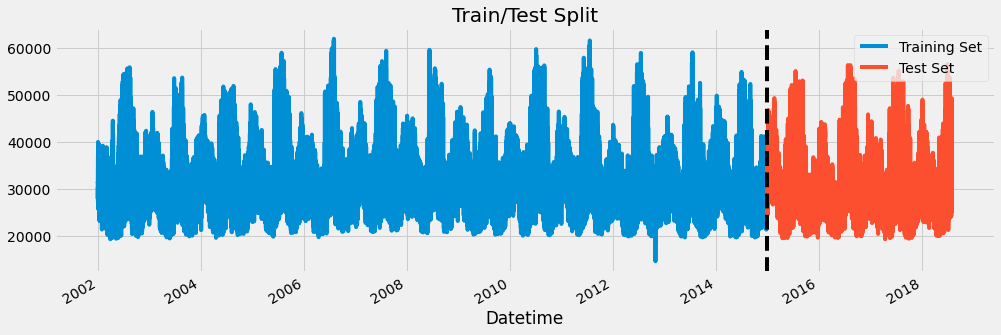

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [61]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

df = normalize_data(df)



In [62]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [63]:
# preprocessing
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'PJME_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [76]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 6189 days are going to be used in test
    X_test = X_train[113912:]
    y_test = y_train[113912:]

    # 2 first 110000 days are going to be used in training
    X_train = X_train[:113912]
    y_train = y_train[:113912]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (113912, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]


In [77]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)


X_train.shape =  (113912, 20, 1)
y_train.shape =  (113912,)
X_test.shape =  (31440, 20, 1)
y_test.shape =  (31440,)


Before moving on to the **RNN model**, a good explaination for beginners to machine learning using RRN models is available at this [link](https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7) 

In [78]:
#RNN model

rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Initial learning rate
                  loss="mse"
                 )


rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_59 (SimpleRNN)   (None, 20, 40)            1680      
                                                                 
 dropout_58 (Dropout)        (None, 20, 40)            0         
                                                                 
 simple_rnn_60 (SimpleRNN)   (None, 20, 40)            3240      
                                                                 
 dropout_59 (Dropout)        (None, 20, 40)            0         
                                                                 
 simple_rnn_61 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dropout_60 (Dropout)        (None, 40)                0         
                                                                 
 dense_18 (Dense)            (None, 1)               

In [79]:
from sklearn.metrics import mean_squared_error
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)

print('r2_score',rnn_score)


983/983 [==============================] - 3s 3ms/step
r2_score 0.96723875165734


983/983 [==============================] - 3s 3ms/step


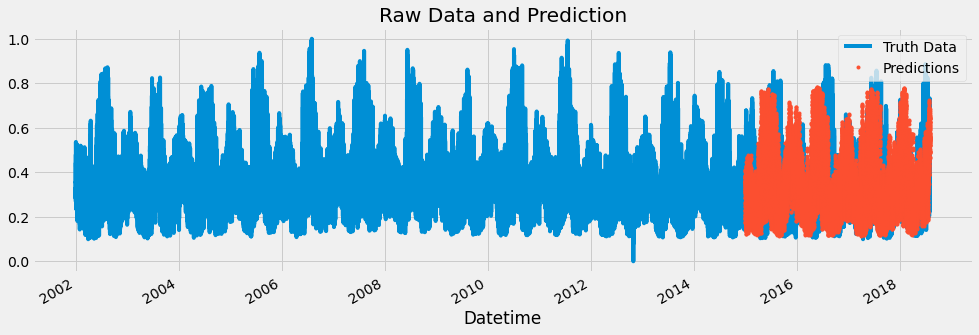

In [81]:
rnn_predictions = rnn_model.predict(X_test)
test['prediction'] = rnn_predictions
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()




That's the simple RNN model used against the energy data, finishing off with a plot the predicted values against the actual values.

Next, we move on to LSTM model as highlighted in the 'Towards Data Science' article on Recurrent Neural Network models.

In [82]:
#train model for LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Initial learning rate
                  loss="mse"
                 )
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_61 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_62 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_63 (Dropout)        (None, 40)                0         
                                                                 
 dense_19 (Dense)            (None, 1)               

In [83]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

983/983 [==============================] - 7s 6ms/step
R^2 Score of LSTM model =  0.992957745591103


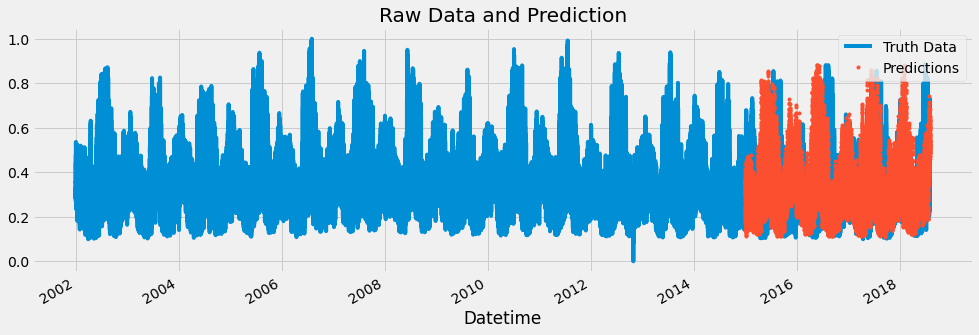

In [84]:
test['prediction2'] = lstm_predictions
df = df.merge(test[['prediction2']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction2'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()


As you will observe from the plot graph which compares the predicted values to the data set, the trained LTSM model provides an accurate prediction of energy values.